In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random
from google.colab import drive
from google.colab import files
import shutil

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from numpy.random import seed
import pickle
seed(1)
tf.random.set_seed(1)

In [ ]:
# mount drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root_path = "/content/drive/Shareddrives/[Deep Learning Project]"
dataset_dir = os.path.join(root_path, "Dataset")
balanced_train_dir = os.path.join(dataset_dir, 'balanced_train') # We're using the balanced dataset
test_dir = os.path.join(dataset_dir, 'balanced_test')

In [ ]:
#Set the parameter used to load the dataset
BATCH_SIZE = 64
IMAGE_HEIGHT = 180
IMAGE_WIDTH = 180

#Creation of the training, validation and test set

We exploit the directory hierarchy of our dataset to infer the classes from the
name of the directories, more details are present in the report about the choices taken.

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    balanced_train_dir,
    labels='inferred', 
    label_mode='categorical',
    class_names=None, 
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    subset="training",
    shuffle=True,
    seed=1024)

validation_dataset = image_dataset_from_directory(
    balanced_train_dir,
    labels='inferred', 
    label_mode='categorical',
    class_names=None, 
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    subset="validation",
    shuffle=True,
    seed=1024)

test_dataset = image_dataset_from_directory(
    test_dir,
    labels='inferred', 
    label_mode='categorical',
    class_names=None, 
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

Found 8100 files belonging to 18 classes.
Using 7290 files for training.
Found 8100 files belonging to 18 classes.
Using 810 files for validation.
Found 1474 files belonging to 18 classes.


In [ ]:
dir_name = os.path.join(root_path, "Models")
if not os.path.exists(dir_name):
  os.makedirs(dir_name)

Let's import the pre-trained model:

In [ ]:
from tensorflow.keras.applications import VGG16

conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [ ]:
import numpy as np

print('This is the number of trainable weights '
      'before freezing the conv base:', sum(np.prod(x.shape) for x in conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 14714688


# Feature extraction

Let's freeze all the layers in the convolution base:

In [ ]:
conv_base.trainable = False

In [ ]:
print('This is the number of trainable weights '
      'after freezing the conv base:', sum(np.prod(x.shape) for x in conv_base.trainable_weights))

# Make sure you have frozen the correct layers
for i, layer in enumerate(conv_base.layers):
    print(i, layer.name, layer.trainable)

This is the number of trainable weights after freezing the conv base: 0
0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False


In [ ]:
from tensorflow.keras import layers

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
])

Now we define the classifier that we will add on top of the convolutional base:

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(18, activation="softmax")(x)

optimizer = keras.optimizers.Adam(learning_rate=1e-3)

model = keras.Model(inputs, outputs)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=["accuracy"])


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 180, 180, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 180, 180, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                             

**Let's add Keras callbacks:**
*   Early stopping
*   ModelCheckpoint
*   ReduceLROnPlateau

In [ ]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=12),

    keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(dir_name, 'VGG16_feature_extraction.h5'),
    monitor='val_loss',
    save_best_only=True,
    ),

    keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    )
]

Train the network:

In [ ]:
history = model.fit(train_dataset,
                    epochs=100,
                    callbacks=callbacks_list,
                    validation_data=validation_dataset
                    )

Epoch 1/100
114/114 [==============================] - 3236s 26s/step - loss: 4.0017 - accuracy: 0.2746 - val_loss: 1.8735 - val_accuracy: 0.4506 - lr: 0.0010
Epoch 2/100
114/114 [==============================] - 38s 316ms/step - loss: 1.9309 - accuracy: 0.4380 - val_loss: 1.5504 - val_accuracy: 0.5605 - lr: 0.0010
Epoch 3/100
114/114 [==============================] - 38s 315ms/step - loss: 1.6220 - accuracy: 0.5086 - val_loss: 1.4462 - val_accuracy: 0.6111 - lr: 0.0010
Epoch 4/100
114/114 [==============================] - 39s 319ms/step - loss: 1.5076 - accuracy: 0.5503 - val_loss: 1.2093 - val_accuracy: 0.6556 - lr: 0.0010
Epoch 5/100
114/114 [==============================] - 39s 315ms/step - loss: 1.3077 - accuracy: 0.5927 - val_loss: 1.1670 - val_accuracy: 0.6790 - lr: 0.0010
Epoch 6/100
114/114 [==============================] - 37s 300ms/step - loss: 1.2028 - accuracy: 0.6280 - val_loss: 1.1839 - val_accuracy: 0.6741 - lr: 0.0010
Epoch 7/100
114/114 [=========================

Shows some plots to better evaluate the model:

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

i = np.argmax(val_acc)
x_min = epochs[i]
y_min = val_acc[i]
plt.plot(x_min, y_min,'g',marker='o', label="Maximum validation accuracy")

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

i = np.argmin(val_loss)
x_min = epochs[i]
y_min = val_loss[i]
plt.plot(x_min, y_min,'g',marker='o', label="Minimum validation loss")

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Fine tuning:

We will **fine-tune the last 3 convolutional layers**, which means that all layers up until `block4_pool` should be frozen, and the layers 
`block5_conv1`, `block5_conv2` and `block5_conv3` should be trainable.

In [ ]:
filepath=os.path.join(dir_name, 'VGG16_feature_extraction.h5')
model=keras.models.load_model(filepath)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 180, 180, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 180, 180, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                             

In [ ]:
model.layers[4].summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [ ]:
model.layers[4].trainable = True
set_trainable = False

for layer in model.layers[4].layers[:15]:
  layer.trainable = False
for layer in model.layers[4].layers[15:]:
  layer.trainable = True

In [ ]:
# Make sure you have frozen the correct layers
for i, layer in enumerate(model.layers[4].layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [ ]:
model.layers[4].summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=1e-5)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 180, 180, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 180, 180, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                             

`Let's add the same Keras callbacks as before and train the model:`

In [ ]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15),

    keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(dir_name, 'VGG16_fine_tuning.h5'),
    monitor='val_loss',
    save_best_only=True,
    ),

    keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    )
]



history = model.fit(train_dataset,
                    epochs=100,
                    callbacks=callbacks_list,
                    validation_data=validation_dataset
                    )

Epoch 1/100
114/114 [==============================] - 1911s 15s/step - loss: 0.3379 - accuracy: 0.8929 - val_loss: 0.6380 - val_accuracy: 0.8679 - lr: 1.0000e-05
Epoch 2/100
114/114 [==============================] - 40s 331ms/step - loss: 0.3481 - accuracy: 0.8894 - val_loss: 0.6542 - val_accuracy: 0.8617 - lr: 1.0000e-05
Epoch 3/100
114/114 [==============================] - 39s 326ms/step - loss: 0.3168 - accuracy: 0.9005 - val_loss: 0.6540 - val_accuracy: 0.8654 - lr: 1.0000e-05
Epoch 4/100
114/114 [==============================] - 41s 339ms/step - loss: 0.3193 - accuracy: 0.8996 - val_loss: 0.5944 - val_accuracy: 0.8704 - lr: 1.0000e-05
Epoch 5/100
114/114 [==============================] - 41s 342ms/step - loss: 0.3058 - accuracy: 0.9026 - val_loss: 0.5874 - val_accuracy: 0.8704 - lr: 1.0000e-05
Epoch 6/100
114/114 [==============================] - 40s 324ms/step - loss: 0.2822 - accuracy: 0.9099 - val_loss: 0.6579 - val_accuracy: 0.8654 - lr: 1.0000e-05
Epoch 7/100
114/114 [=

Plotting the Training and Validation Loss Curves:

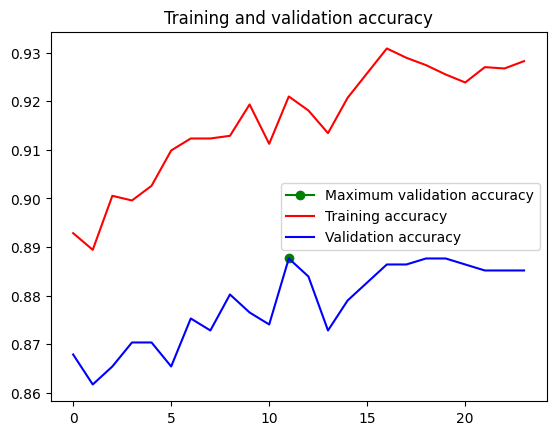

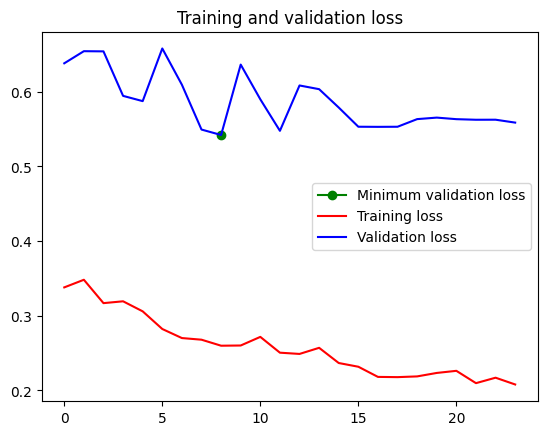

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

i = np.argmax(val_acc)
x_min = epochs[i]
y_min = val_acc[i]
plt.plot(x_min, y_min,'g',marker='o', label="Maximum validation accuracy")

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

i = np.argmin(val_loss)
x_min = epochs[i]
y_min = val_loss[i]
plt.plot(x_min, y_min,'g',marker='o', label="Minimum validation loss")

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
#Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_dataset)

#Save the rusults in the history dictionary
history.history["test_loss"] = test_loss
history.history["test_accuracy"] = test_acc

print('test_acc:', test_acc)
print('test_loss:', test_loss)

18/18 [==============================] - 273s 8s/step - loss: 2.4430 - accuracy: 0.6727
test_acc: 0.6726618409156799
test_loss: 2.4429805278778076


# Confusion matrix

In [ ]:
filepath=os.path.join(dir_name, 'VGG16_fine_tuning.h5')
model=keras.models.load_model(filepath)

Let's define some functions in order to retrieve the misclassified paintings:

In [ ]:
def get_images_predictions(test_dataset, true_class, predicted_class):

  images = []

  # iterate over the dataset
  for image_batch, label_batch in test_dataset:   # use dataset.unbatch() with repeat
    # compute predictions
    preds = model.predict(image_batch)

    for i in range(len(label_batch)):
      if((label_batch[i][true_class] == 1) and (np.argmax(preds, axis=-1)[i] == predicted_class)):
          images.append(image_batch[i].numpy().astype("uint8"))
          
  return images

In [ ]:
def print_predictions(images, true_class, predicted_class):
  fig = plt.figure(figsize=(9.9, 9.8))
  fig.suptitle("Predicted class: " + class_names[predicted_class]+ "\nCorrect class: "+class_names[true_class])

  for i, image in enumerate(images):
    ax = plt.subplot(4,(len(images)//4)+1,i + 1)
    plt.imshow(images[i])
    ax.axis("off")

  # plt.subplots_adjust(hspace=0.001, wspace=0.5)
  
  plt.tight_layout()
  plt.show()          

In [ ]:
images = get_images_predictions(test_dataset, 10, 17)

1/1 [==============================] - 1s 694ms/step


Function to plot the Confusion matrix:

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(rounded_labels, predicted_labels, title):
  cm = confusion_matrix(rounded_labels, predicted_labels)
  fig = plt.figure(figsize = (9,8))
  ax1 = fig.add_subplot(1,1,1)
  ax1.set_title(title)
  sns.set(font_scale=1.1) #for label size
  sns.heatmap(cm, annot=True, annot_kws={"size": 10},cbar = True, cmap='Purples', fmt="d");
  ax1.set_ylabel('True Values',fontsize=14)
  ax1.set_xlabel('Predicted Values',fontsize=14)

  plt.show()

Let's define a function to print a table with the accuracies per class:

In [ ]:
def print_perc_table(class_names, rounded_labels, predicted_labels):

  counter_correct=[0 for i in range(18)]
  counter_errors=[0 for i in range(18)]
  counter_tot=[0 for i in range(18)]
  perc=[0 for i in range(18)]

  for count in range(len(rounded_labels)):
    if rounded_labels[count]==predicted_labels[count]:
      counter_correct[rounded_labels[count]]+=1
    else:
      counter_errors[rounded_labels[count]]+=1

  for i in range(18):
    counter_tot[i]=counter_correct[i]+counter_errors[i]
    perc[i]="{:.2f}".format(counter_correct[i]/counter_tot[i])

  data = np.array([np.array(class_names),np.array(perc)])
  return pd.DataFrame( perc,
    index=class_names,
    columns=["Accuracy"])

In [ ]:
def take_classes_size(directory):
  classes_size=[]
  classes_name=[]
  for dir in os.listdir(directory):
    dir_size=len(os.listdir(directory+"/"+dir))
    classes_size.append(dir_size)
    classes_name.append(dir)
    print(dir+": ",dir_size)
  return classes_name,classes_size

In [ ]:
classes_name, classes_size = take_classes_size(test_dir)
print("\nTotal paintings:", sum(classes_size))

Rene Magritte:  39
Edgar Degas:  240
Mikhail Vrubel:  35
Titian:  51
Albrecht Dürer:  66
Francisco Goya:  59
Andy Warhol:  37
Henri Matisse:  38
Paul Klee:  38
Pierre-Auguste Renoir:  68
Alfred Sisley:  52
Sandro Botticelli:  33
Marc Chagall:  48
Vincent van Gogh:  427
Amedeo Modigliani:  39
Pablo Picasso:  88
Paul Gauguin:  63
Rembrandt:  53

Total paintings: 1474


In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 [==============================] - 0s 29ms/step


In [ ]:
class_names=test_dataset.class_names
rounded_labels=np.argmax(correct_labels, axis=1)

In [ ]:
print_predictions(images, 10, 17)

In [ ]:
print_perc_table(class_names, rounded_labels, predicted_labels)

,Accuracy
Albrecht Dürer,0.79
Alfred Sisley,0.90
Amedeo Modigliani,0.85
Andy Warhol,0.68
Edgar Degas,0.79
Francisco Goya,0.64
Henri Matisse,0.42
Marc Chagall,0.54
Mikhail Vrubel,0.26
Pablo Picasso,0.72


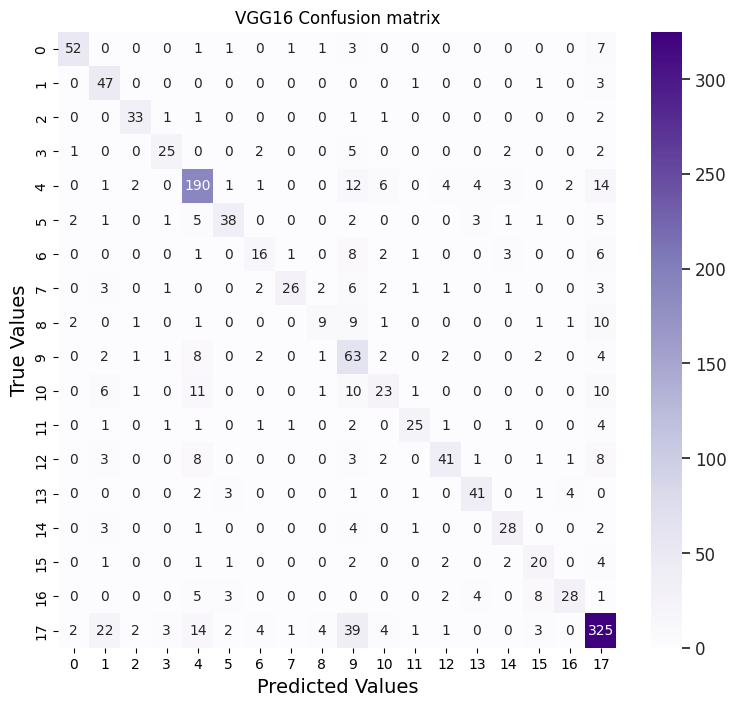

In [ ]:
plot_confusion_matrix(rounded_labels,predicted_labels,"VGG16 Confusion matrix")